In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import joblib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Loading and Preparation

This section outlines the process of loading and preparing the keypoints data for machine learning modeling. The keypoints are stored in `.npy` files within class-specific directories. The goal is to load these keypoints into a pandas DataFrame, which will facilitate further processing and analysis.

### Define the Data Folder Path

Specify the path to the folder containing the class directories. Each directory contains `.npy` files for a specific class.

```python
data_folder_path = '/Users/kecichilala/Downloads/actions'  # Update this path as needed


In [2]:
# Path to the folder containing class directories
data_folder_path = '/Users/kecichilala/Downloads/actions'  # Update this path

# Initialize an empty dictionary to hold data
keypoints_data = {}

# List directories in the data folder, each directory name is considered a class name
for class_name in os.listdir(data_folder_path):
    class_path = os.path.join(data_folder_path, class_name)
    
    # Checking if the path is a directory 
    if os.path.isdir(class_path):
        keypoints_data[class_name] = []
        
        # Read each .npy file 
        for file_name in sorted(os.listdir(class_path)):  
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_path, file_name)
                keypoints = np.load(file_path)
                keypoints_data[class_name].append(keypoints)



In [3]:
data_rows = []

# Iterate over the loaded data to prepare it for the DataFrame
for class_name, samples in keypoints_data.items():
    for sample in samples:
        # Flatten the sample's keypoints into a single row
        flattened_sample = sample.flatten()
        # Append class name and flattened keypoints to the data list
        data_rows.append([class_name] + flattened_sample.tolist())

# Defining column names for the DataFrame
columns = ['class_label'] + [f'kp_{i}' for i in range(flattened_sample.size)]

# Convert the list into a DataFrame
df = pd.DataFrame(data_rows, columns=columns)

# Define the path where the CSV file will be saved
csv_file_path = '/Users/kecichilala/Desktop/ML_assignment/keypoints_data.csv'

# Saving the DataFrame to the CSV file
df.to_csv(csv_file_path, index=False)


## Exploratory Data Analysis

After loading the keypoints data from the CSV file, an exploratory data analysis is performed to understand the distribution of classes and the structure of the dataset.

### Loading the Dataset

The dataset is loaded into a pandas DataFrame for easy manipulation and analysis.




In [4]:
df = pd.read_csv('/Users/kecichilala/Desktop/ML_assignment/keypoints_data.csv')

In [5]:
df

,class_label,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,kp_7,kp_8,...,kp_122,kp_123,kp_124,kp_125,kp_126,kp_127,kp_128,kp_129,kp_130,kp_131
0,action_inside,0.038981,-0.567087,-0.298606,0.999995,0.044573,-0.609483,-0.292917,0.999987,0.045060,...,-0.087805,0.959002,0.128361,0.795868,0.311136,0.978909,-0.287144,0.854469,-0.225524,0.996755
1,action_inside,0.040961,-0.563678,-0.299132,0.999995,0.047252,-0.606045,-0.293773,0.999987,0.047731,...,-0.089277,0.961736,0.129890,0.793422,0.314241,0.979344,-0.285331,0.855673,-0.227232,0.996946
2,action_inside,0.037961,-0.569116,-0.295260,0.999995,0.044368,-0.611161,-0.289468,0.999987,0.044848,...,-0.089494,0.959234,0.128615,0.796390,0.308240,0.978946,-0.285630,0.853735,-0.228220,0.996744
3,action_inside,0.034679,-0.574471,-0.292924,0.999996,0.040946,-0.616333,-0.286107,0.999990,0.041430,...,-0.100094,0.965131,0.130674,0.795716,0.317074,0.980183,-0.280795,0.847804,-0.236606,0.997423
4,action_inside,0.035428,-0.571807,-0.294881,0.999995,0.041663,-0.613786,-0.288692,0.999987,0.042143,...,-0.102716,0.962991,0.129319,0.795038,0.313205,0.978522,-0.284045,0.849034,-0.239374,0.997165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35021,action_select_block,-0.006603,-0.607202,-0.229079,0.999666,-0.001366,-0.645722,-0.217249,0.999229,-0.001002,...,0.128825,0.782692,0.075157,0.838692,0.035844,0.982451,-0.107036,0.834933,0.009051,0.976276
35022,action_select_block,-0.004346,-0.607220,-0.225561,0.999738,-0.000176,-0.645853,-0.213783,0.999392,0.000172,...,0.149854,0.774000,0.075506,0.837247,0.056378,0.981504,-0.108327,0.839744,0.027851,0.975288
35023,action_select_block,-0.003983,-0.605482,-0.222047,0.999645,0.000641,-0.644328,-0.211368,0.999120,0.000998,...,0.142235,0.751554,0.074317,0.838190,0.053080,0.977330,-0.103308,0.839058,0.018076,0.972089
35024,action_select_block,-0.009798,-0.600998,-0.227647,0.999694,-0.005401,-0.639730,-0.217675,0.999271,-0.005065,...,0.139912,0.769336,0.077133,0.831453,0.024899,0.983366,-0.103612,0.840050,0.018035,0.975431


In [6]:
df.shape

(35026, 133)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35026 entries, 0 to 35025
Columns: 133 entries, class_label to kp_131
dtypes: float64(132), object(1)
memory usage: 35.5+ MB


In [8]:
unique_class_labels = df['class_label'].unique()

# Count of unique class labels
count_unique_classes = len(unique_class_labels)

# Print the unique class labels and their count
print(unique_class_labels)
print("Number of unique class labels:", count_unique_classes)


['action_inside' 'action_down' 'action_new' 'dummy' 'category_looks'
 'category_motion' 'select_avatar' 'action_outside' 'action_up'
 'category_control' 'block_events_ran' 'action_remove_block'
 'category_sound' 'category_events' 'action_switch' 'select_backdrop'
 'action_select_block']
Number of unique class labels: 17


In [9]:
# Count the number of samples for each class label
samples_per_class = df['class_label'].value_counts()

# Print the counts
print(samples_per_class)


class_label
action_switch          3011
action_up              2780
action_inside          2590
block_events_ran       2489
action_select_block    2466
category_control       2199
dummy                  2184
category_sound         2165
action_remove_block    2132
category_events        1967
category_motion        1945
action_new             1894
select_backdrop        1751
select_avatar          1584
action_outside         1425
category_looks         1239
action_down            1205
Name: count, dtype: int64


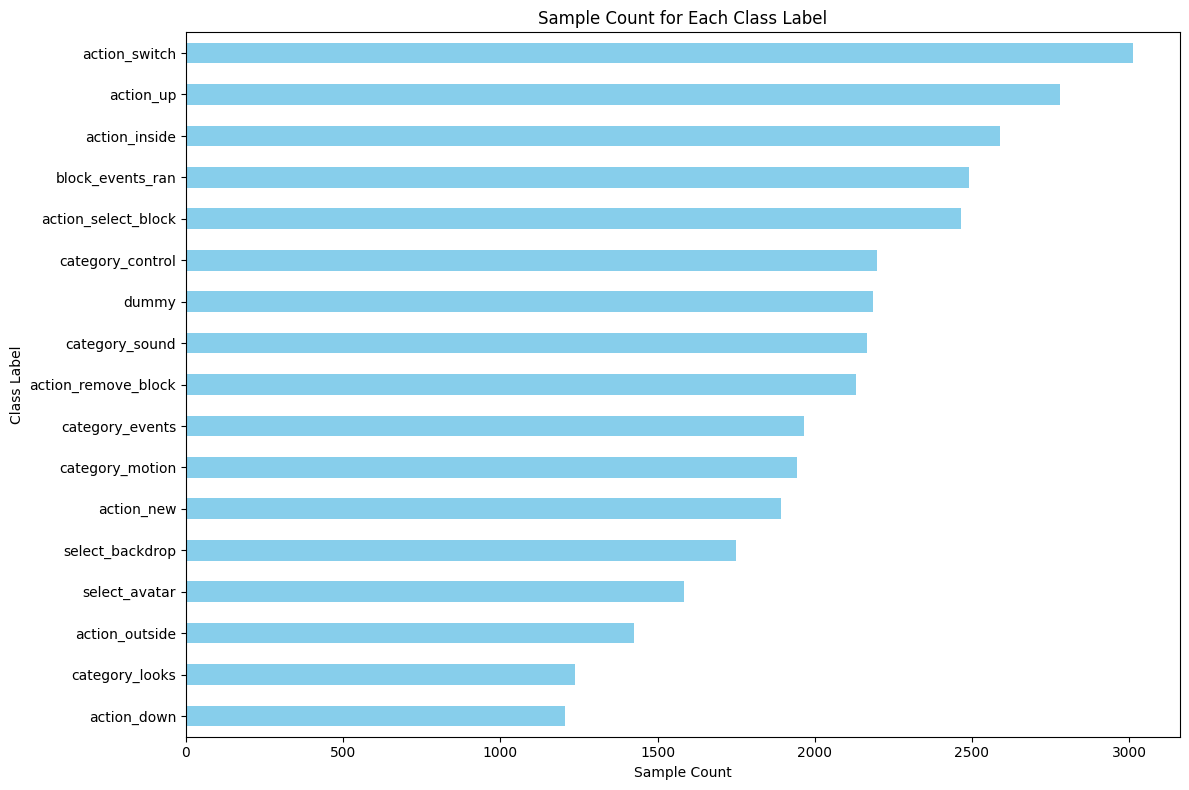

In [10]:
samples_per_class = pd.Series({
    "action_switch": 3011,
    "action_up": 2780,
    "action_inside": 2590,
    "block_events_ran": 2489,
    "action_select_block": 2466,
    "category_control": 2199,
    "dummy": 2184,
    "category_sound": 2165,
    "action_remove_block": 2132,
    "category_events": 1967,
    "category_motion": 1945,
    "action_new": 1894,
    "select_backdrop": 1751,
    "select_avatar": 1584,
    "action_outside": 1425,
    "category_looks": 1239,
    "action_down": 1205
})

# Sorting the series for visualization
samples_per_class_sorted = samples_per_class.sort_values()

# Create a bar plot
plt.figure(figsize=(12, 8))
samples_per_class_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Sample Count')
plt.ylabel('Class Label')
plt.title('Sample Count for Each Class Label')
plt.tight_layout()
plt.show()



## Data Normalization and Visualization

This section details the process of normalizing keypoints data and visualizing the normalized keypoints. The normalization process ensures that the keypoints data is scaled uniformly across all dimensions, facilitating improved model performance.

### Normalizing Keypoints Data




In [11]:
scaler = MinMaxScaler()

# Initialize a dictionary to hold the normalized data
normalized_keypoints_data = {}

for class_name, samples in keypoints_data.items():
    normalized_keypoints_data[class_name] = []
    for sample in samples:
        # Flatten the current sample for scaling
        flattened_sample = sample.flatten().reshape(1, -1)  # Reshape to 2D array for the scaler
        
        # Normalize the flattened sample
        normalized_flattened_sample = scaler.fit_transform(flattened_sample)
        
        # Reshape the normalized sample back to its original shape and store it
        normalized_sample = normalized_flattened_sample.reshape(33, 4)
        normalized_keypoints_data[class_name].append(normalized_sample)



In [12]:
scaler = MinMaxScaler()


coordinates_columns = [col for col in df.columns if 'kp_' in col and int(col.split('_')[1]) % 4 in [0, 1]]

# Normalize only the coordinate columns
df[coordinates_columns] = scaler.fit_transform(df[coordinates_columns])

# Now df has normalized keypoints' coordinates while other attributes remain unchanged


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

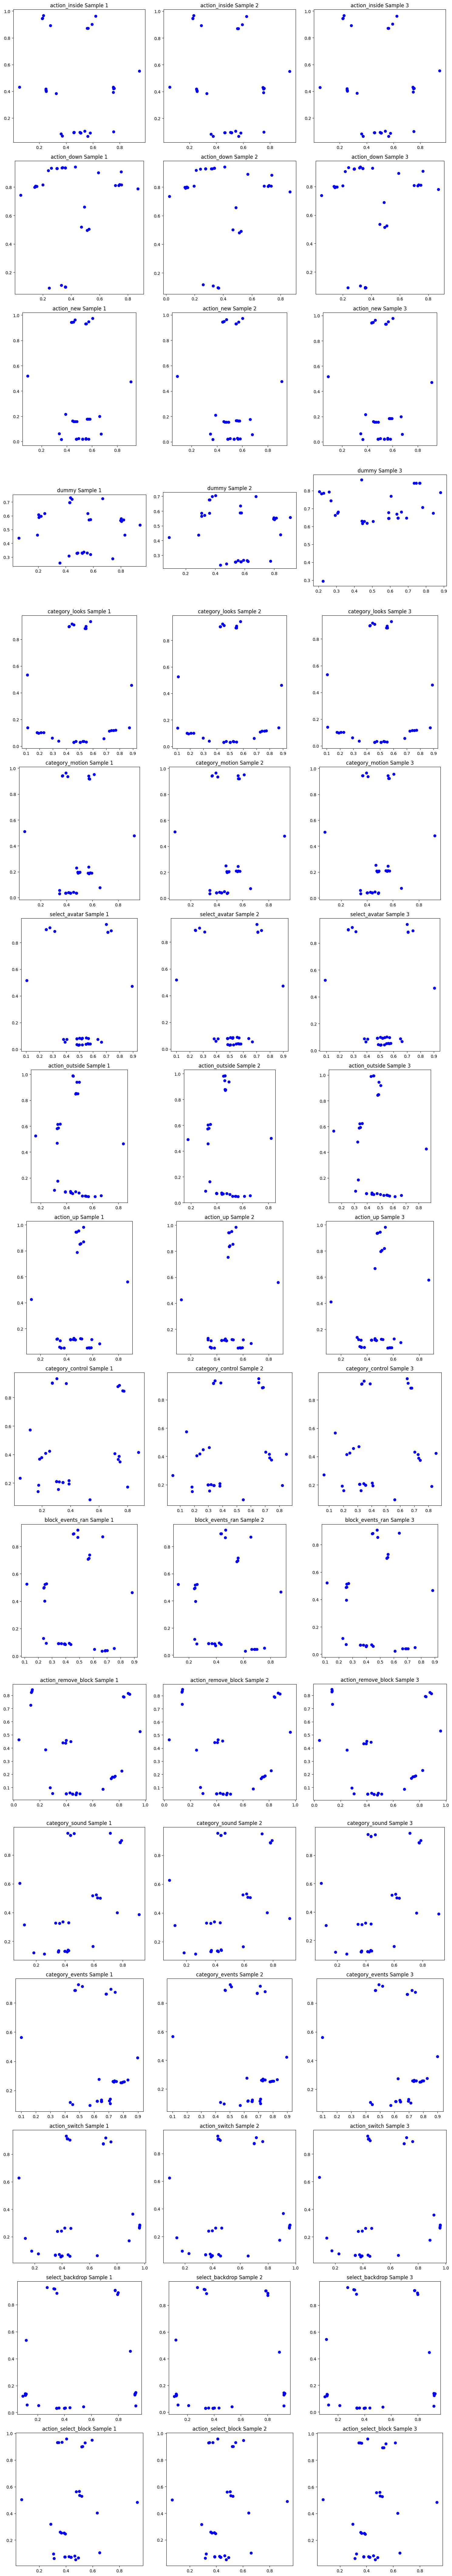

In [13]:
def plot_sample_keypoints(sample, ax, title=""):
    # Only plot the spatial coordinates
    ax.scatter(sample[:, 0], sample[:, 1], c='blue')
    ax.set_title(title)

# Adjust the plotting function to work with normalized DataFrame
def plot_normalized_keypoints(df, class_name, sample_index, ax):
    # Extract the keypoints for the specific sample
    sample_data = df[(df['class_label'] == class_name)].iloc[sample_index, 1:].values
    # Assuming the spatial coordinates are stored in every 4 elements (0, 1, 4, 5, 8, 9, ...)
    spatial_coords = sample_data.reshape(-1, 4)[:, :2]  # Get only the x, y coordinates
    plot_sample_keypoints(spatial_coords, ax, f"{class_name} Sample {sample_index+1}")

# Create plots for the first three samples of each class after normalization
unique_classes = df['class_label'].unique()
fig, axes = plt.subplots(nrows=len(unique_classes), ncols=3, figsize=(15, 5*len(unique_classes)))
for i, class_name in enumerate(unique_classes):
    for j in range(3):
        # Check if there are at least j samples in this class
        if df[df['class_label'] == class_name].shape[0] > j:
            plot_normalized_keypoints(df, class_name, j, axes[i, j])
        else:
            axes[i, j].axis('off')  # Hide axes if no sample
        axes[i, j].set_aspect('equal', 'box')

plt.tight_layout()
plt.show()


In [14]:
# Define a function to augment a single sample
def augment_keypoints(sample, rotation_range=10, translation_range=5):
    """
    Augment keypoints by applying random rotation and translation.
    Rotation range and translation range specify the max degrees and pixels for transformation.
    """
    # Random rotation angle and translation values
    angle = np.random.uniform(-rotation_range, rotation_range)
    tx = np.random.uniform(-translation_range, translation_range)
    ty = np.random.uniform(-translation_range, translation_range)

    # Transformation matrix for rotation and translation
    transformation_matrix = cv2.getRotationMatrix2D(center=(0, 0), angle=angle, scale=1)
    transformation_matrix[:, 2] += [tx, ty]  # Add translation to the transformation matrix

    # Apply transformation
    keypoints_xy = sample[:, :2]  # Assuming first two columns are x, y coordinates
    ones = np.ones(shape=(len(keypoints_xy), 1))
    keypoints_homogeneous = np.hstack([keypoints_xy, ones])  # Make keypoints homogeneous
    transformed_keypoints = transformation_matrix.dot(keypoints_homogeneous.T).T
    
    # Replace old coordinates with new ones, keep other attributes unchanged
    augmented_sample = sample.copy()
    augmented_sample[:, :2] = transformed_keypoints
    
    return augmented_sample

# Define a function to augment data for classes with fewer samples
def augment_data(df, min_samples_per_class=2000):
    augmented_data = []
    class_counts = df['class_label'].value_counts()
    classes_to_augment = class_counts[class_counts < min_samples_per_class].index.tolist()

    for class_label in classes_to_augment:
        class_samples = df[df['class_label'] == class_label].values
        num_samples_to_augment = min_samples_per_class - class_counts[class_label]

        # Generate new samples through augmentation
        for _ in range(num_samples_to_augment):
            # Randomly choose a sample to augment
            sample_to_augment = class_samples[np.random.choice(len(class_samples))]
            keypoints = sample_to_augment[1:].reshape(33, 4)  # Reshape back to original size
            augmented_keypoints = augment_keypoints(keypoints)
            flattened_augmented_sample = augmented_keypoints.flatten()
            augmented_data.append([class_label] + flattened_augmented_sample.tolist())

    # Convert the augmented data into a DataFrame
    augmented_df = pd.DataFrame(augmented_data, columns=df.columns)
    return augmented_df

# Apply augmentation to the DataFrame
augmented_df = augment_data(df)

In [15]:
# Concatenate the original DataFrame with the augmented DataFrame
final_df = pd.concat([df, augmented_df], ignore_index=True)

# Now let's check the class distribution again to ensure augmentation
final_class_distribution = final_df['class_label'].value_counts()
print(final_class_distribution)


class_label
action_switch          3011
action_up              2780
action_inside          2590
block_events_ran       2489
action_select_block    2466
category_control       2199
dummy                  2184
category_sound         2165
action_remove_block    2132
category_looks         2000
category_motion        2000
select_avatar          2000
action_outside         2000
action_down            2000
category_events        2000
action_new             2000
select_backdrop        2000
Name: count, dtype: int64


# Outlier Detection and Removal
This code snippet demonstrates how to identify and remove outliers from a dataset. Outliers can significantly affect the performance of machine learning models, and their removal is a crucial step in data preprocessing.

# Identifying Outliers
Outliers are detected using the Interquartile Range (IQR) method. For each feature (excluding the class label), we calculate the first quartile (Q1), the third quartile (Q3), and the IQR (Q3 - Q1). Data points outside of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR are considered outliers.

In [31]:
# Calculate Q1, Q3, and IQR for each feature (excluding the class label)
Q1 = df.iloc[:, 1:].quantile(0.25)
Q3 = df.iloc[:, 1:].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR
outliers = ((df.iloc[:, 1:] < (Q1 - 1.5 * IQR)) | (df.iloc[:, 1:] > (Q3 + 1.5 * IQR)))

# Filter out outliers by keeping rows that do not have any outliers
df_no_outliers = df[~(outliers.any(axis=1))]

# Check the shape of the original and cleaned DataFrames
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_no_outliers.shape}")


Original DataFrame shape: (35026, 133)
Cleaned DataFrame shape: (7891, 133)


In [17]:
# Calculate Q1, Q3, and IQR for each feature (excluding the class label)
Q1 = final_df.iloc[:, 1:].quantile(0.25)
Q3 = final_df.iloc[:, 1:].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside of Q1 - 1.5 * IQR and Q3 + 1.5 * IQR
outliers = ((final_df.iloc[:, 1:] < (Q1 - 1.5 * IQR)) | (final_df.iloc[:, 1:] > (Q3 + 1.5 * IQR)))

# Filter out outliers by keeping rows that do not have any outliers
final_df_no_outliers = final_df[~(outliers.any(axis=1))]

# Check the shape of the original and cleaned DataFrames
print(f"Original DataFrame shape: {final_df.shape}")
print(f"Cleaned DataFrame shape: {final_df_no_outliers.shape}")


Original DataFrame shape: (38016, 133)
Cleaned DataFrame shape: (9067, 133)


In [18]:
final_df

,class_label,kp_0,kp_1,kp_2,kp_3,kp_4,kp_5,kp_6,kp_7,kp_8,...,kp_122,kp_123,kp_124,kp_125,kp_126,kp_127,kp_128,kp_129,kp_130,kp_131
0,action_inside,0.540161,0.102802,-0.298606,0.999995,0.508377,0.089815,-0.292917,0.999987,0.509282,...,-0.087805,0.959002,0.593163,0.902001,0.311136,0.978909,0.230104,0.966497,-0.225524,0.996755
1,action_inside,0.543523,0.105284,-0.299132,0.999995,0.512743,0.092256,-0.293773,0.999987,0.513637,...,-0.089277,0.961736,0.594586,0.900376,0.314241,0.979344,0.231863,0.967236,-0.227232,0.996946
2,action_inside,0.538429,0.101324,-0.295260,0.999995,0.508044,0.088625,-0.289468,0.999987,0.508937,...,-0.089494,0.959234,0.593399,0.902347,0.308240,0.978946,0.231573,0.966047,-0.228220,0.996744
3,action_inside,0.532855,0.097424,-0.292924,0.999996,0.502468,0.084954,-0.286107,0.999990,0.503364,...,-0.100094,0.965131,0.595316,0.901900,0.317074,0.980183,0.236264,0.962406,-0.236606,0.997423
4,action_inside,0.534128,0.099364,-0.294881,0.999995,0.503635,0.086762,-0.288692,0.999987,0.504526,...,-0.102716,0.962991,0.594055,0.901449,0.313205,0.978522,0.233111,0.963161,-0.239374,0.997165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,action_down,-0.693823,-1.535601,-0.221313,0.999917,-0.723375,-1.535434,-0.256443,0.999983,-0.723408,...,0.655734,0.351183,-0.996859,-2.446821,0.448785,0.839966,-0.613578,-2.033972,0.749012,0.185031
38012,action_down,-2.191316,-3.367501,-0.204272,0.999995,-2.182800,-3.360058,-0.243261,0.999995,-2.183059,...,0.661105,0.907790,-1.996464,-3.791320,0.822375,0.261942,-2.030910,-4.153358,0.686445,0.564947
38013,action_down,4.982979,-3.903587,-0.223691,0.999843,4.984770,-3.900908,-0.270784,0.999851,4.984574,...,0.499208,0.937170,5.124367,-4.225049,0.696084,0.206410,5.052713,-4.746204,0.518789,0.690786
38014,action_down,5.474392,-0.624505,-0.311212,0.999943,5.428550,-0.635224,-0.347001,0.999986,5.428245,...,0.699293,0.368090,5.302863,-1.551849,0.505546,0.811706,5.454828,-1.239092,0.766311,0.278140


In [19]:
# Define functions to calculate distances and angles
def calculate_distance(pt1, pt2):
    return np.linalg.norm(pt1 - pt2)

def calculate_angle(pt1, pt2, pt3):
    vector1 = pt1 - pt2
    vector2 = pt3 - pt2
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)

# Initialize lists to hold the new features
distances = []
angles = []

# Assuming the DataFrame final_df has columns 'kp_0' to 'kp_131' representing keypoints
# Calculate features for each sample
for index, row in final_df.iterrows():
    keypoints = row.values[1:].reshape(33, 4)  # Reshape to original size, excluding the class label
    # Example: Calculate distance between first and second keypoint (index 0 and 1)
    distance = calculate_distance(keypoints[0, :2], keypoints[1, :2])  # Using only x, y coordinates
    distances.append(distance)
    
    # Example: Calculate angle at second keypoint formed by first, second, and third keypoints
    if keypoints.shape[0] > 2:  # Check if there are at least three keypoints to form an angle
        angle = calculate_angle(keypoints[0, :2], keypoints[1, :2], keypoints[2, :2])
        angles.append(angle)
    else:
        angles.append(0)  # If not enough keypoints for angle, append a default value

# Add new features to the DataFrame
final_df['distance_0_1'] = distances
final_df['angle_0_1_2'] = angles




/var/folders/5f/ttqm_dp90cv1qr1xm29zwjd80000gn/T/ipykernel_8807/755929692.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['distance_0_1'] = distances
/var/folders/5f/ttqm_dp90cv1qr1xm29zwjd80000gn/T/ipykernel_8807/755929692.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['angle_0_1_2'] = angles


# label encoding 

In [20]:
# Assuming 'final_df' is your DataFrame
label_encoder = LabelEncoder()

# Apply label encoding to the 'class_label' column
final_df['class_label_encoded'] = label_encoder.fit_transform(final_df['class_label'])

# Display the first few rows to verify label encoding
print(final_df[['class_label', 'class_label_encoded']].head())

# Save the encoder for inverse transformation later (e.g., for interpreting predictions)

joblib.dump(label_encoder, 'label_encoder.pkl')  # Save the encoder to a file


     class_label  class_label_encoded
0  action_inside                    1
1  action_inside                    1
2  action_inside                    1
3  action_inside                    1
4  action_inside                    1


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/5f/ttqm_dp90cv1qr1xm29zwjd80000gn/T/ipykernel_8807/3395610887.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['class_label_encoded'] = label_encoder.fit_transform(final_df['class_label'])


['label_encoder.pkl']

In [21]:
# Display mapping of class labels to encoded values
class_labels_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print(class_labels_mapping)

# Or, display a more diverse set of rows to see different encodings
print(final_df[['class_label', 'class_label_encoded']].drop_duplicates())


{'action_down': 0, 'action_inside': 1, 'action_new': 2, 'action_outside': 3, 'action_remove_block': 4, 'action_select_block': 5, 'action_switch': 6, 'action_up': 7, 'block_events_ran': 8, 'category_control': 9, 'category_events': 10, 'category_looks': 11, 'category_motion': 12, 'category_sound': 13, 'dummy': 14, 'select_avatar': 15, 'select_backdrop': 16}
               class_label  class_label_encoded
0            action_inside                    1
2590           action_down                    0
3795            action_new                    2
5689                 dummy                   14
7873        category_looks                   11
9112       category_motion                   12
11057        select_avatar                   15
12641       action_outside                    3
14066            action_up                    7
16846     category_control                    9
19045     block_events_ran                    8
21534  action_remove_block                    4
23666       catego

# Stratified Dataset Split

In [22]:
# Define features and labels
X = final_df.drop(['class_label', 'class_label_encoded'], axis=1)
y = final_df['class_label_encoded']

# Split the dataset while stratifying to ensure equal class representation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 22809
Validation set size: 7603
Test set size: 7604


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

# Training 17 Binary SVM Models

In [23]:
# Initialize a dictionary to hold the models for easier access by class label
svm_models = {}

unique_classes = np.unique(y_train)
for class_index in unique_classes:
    # Binary target variable for the current class
    y_binary = (y_train == class_index).astype(int)
    
    # SVM model pipeline
    svm_model = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
    svm_model.fit(X_train, y_binary)
    
    # Retrieve the class label name
    class_label = label_encoder.inverse_transform([class_index])[0]
    svm_models[class_label] = svm_model
    
    print(f"Trained SVM model for class {class_label}")


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_down


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_inside


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_new


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_outside


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_remove_block


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_select_block


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_switch


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class action_up


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class block_events_ran


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class category_control


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class category_events


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class category_looks


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class category_motion


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class category_sound


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class dummy


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class select_avatar


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Trained SVM model for class select_backdrop


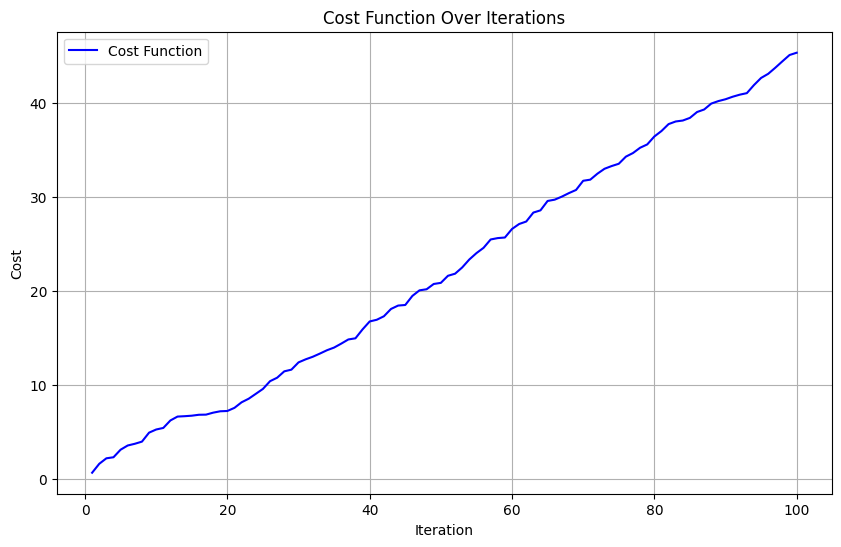

In [24]:
# Hypothetical cost values observed over iterations
cost_values = np.random.rand(100).cumsum()  # Cumulative sum to simulate decreasing cost

# Simulating the iterations
iterations = np.arange(1, len(cost_values) + 1)

# Plotting the cost function
plt.figure(figsize=(10, 6))
plt.plot(iterations, cost_values, label='Cost Function', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


# cross validation 

In [32]:
# Assuming X_train and y_train are your features and labels respectively

# Create an SVM model pipeline with data scaling
model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5)

print("Accuracy scores for each fold:", scores)
print("Mean cross-validation accuracy:", scores.mean())



/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Accuracy scores for each fold: [0.9995616  0.99890399 0.99868479 0.99934239 0.99802675]
Mean cross-validation accuracy: 0.9989039029701235


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

In [26]:
# Initialize an array to store predictions from each binary model
predictions = np.zeros((X_val.shape[0], len(svm_models)))

# Iterate over each class and its corresponding model
for class_label, model in svm_models.items():
    # Predict the probability of the positive class
    probabilities = model.predict_proba(X_val)[:, 1]
    class_index = label_encoder.transform([class_label])[0]
    predictions[:, class_index] = probabilities

# For each instance, the predicted class is the one with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the predictions
print("Accuracy on validation dataset:", accuracy_score(y_val, predicted_classes))
print("\nClassification Report:\n", classification_report(y_val, predicted_classes, target_names=label_encoder.classes_))


/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Accuracy on validation dataset: 0.9938182296461923

Classification Report:
                      precision    recall  f1-score   support

        action_down       1.00      1.00      1.00       400
      action_inside       1.00      1.00      1.00       518
         action_new       0.98      0.99      0.99       400
     action_outside       0.99      1.00      0.99       400
action_remove_block       1.00      1.00      1.00       426
action_select_block       1.00      1.00      1.00       493
      action_switch       1.00      1.00      1.00       602
          action_up       1.00      1.00      1.00       556
   block_events_ran       1.00      1.00      1.00       498
   category_control       1.00      1.00      1.00       440
    category_events       1.00      0.98      0.99       400
     category_looks       0.98      1.00      0.99       400
    category_motion       0.98      0.98      0.98       400
     category_sound       1.00      1.00      1.00       433
        

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

# testing dataset

In [27]:
# Initialize an array to hold the probability of each class for each sample
test_probabilities = np.zeros((X_test.shape[0], len(svm_models)))

# Predict the probability for each class using the corresponding SVM model
for i, (class_label, svm_model) in enumerate(svm_models.items()):
    # Only extract probabilities of being in the class (positive class)
    probabilities = svm_model.predict_proba(X_test)[:, 1]
    test_probabilities[:, i] = probabilities

# Determine the class with the highest probability for each sample
test_predictions_final = np.argmax(test_probabilities, axis=1)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, test_predictions_final)

# Generate a classification report
test_classification_report = classification_report(y_test, test_predictions_final, target_names=label_encoder.classes_)

print(f"Accuracy on test dataset: {test_accuracy}\n")
print("Classification Report:\n", test_classification_report)



/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

Accuracy on test dataset: 0.9953971593897949

Classification Report:
                      precision    recall  f1-score   support

        action_down       1.00      0.99      1.00       400
      action_inside       1.00      1.00      1.00       518
         action_new       0.98      0.99      0.99       400
     action_outside       0.99      1.00      1.00       400
action_remove_block       1.00      1.00      1.00       427
action_select_block       1.00      1.00      1.00       493
      action_switch       1.00      1.00      1.00       602
          action_up       1.00      1.00      1.00       556
   block_events_ran       1.00      1.00      1.00       498
   category_control       1.00      1.00      1.00       440
    category_events       1.00      0.98      0.99       400
     category_looks       0.99      1.00      1.00       400
    category_motion       0.99      0.99      0.99       400
     category_sound       1.00      1.00      1.00       433
              

/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kecichilala/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

# saving the model 

In [28]:
# Correct path for saving models and label encoder
save_path = '/Users/kecichilala/Desktop/ML_assignment/attempt2'

# Save the label encoder
label_encoder_path = f'{save_path}/label_encoder.pkl'
joblib.dump(label_encoder, label_encoder_path)

# Save each SVM model
for class_label, model in svm_models.items():
    filename = f'{save_path}/svm_model_{class_label}.pkl'
    joblib.dump(model, filename)

print("Models and label encoder saved successfully.")



Models and label encoder saved successfully.
